### Project - Sales Trends In The Gaming Industry

### Introduction
This report observes a time-series dataset consisting of daily sales data, from one of the largest Russian
software firms - 1C Company. The company specializes in the development, distribution, publishing, and
support of mass-market software. Using the dataset within a 3-year timeframe, we will explore and
predict total sales of the company for the next six months.

### Objective
To develop a predictive model that can forecast the number of items sold by 1C Company during
November 2015 to April 2016.
The Predict Future Sales Data Set from Kaggle was utilized, which included extensive details from nearly
every item sold by the company between January 2013 and October 2015. Time series forecasting is one
of the critical building blocks of Machine Learning. We will use the Seasonal Autoregressive Integrated
Moving Average (SARIMA) model to create a forecast and analyze the results of this model.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [73]:
# Loading datasets into a dataframe

df_train = pd.read_csv('/content/drive/MyDrive/Machine Learning /sales_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Machine Learning /test.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Machine Learning /items.csv')
df_itemcat = pd.read_csv('/content/drive/MyDrive/Machine Learning /item_categories.csv')
df_shops = pd.read_csv('/content/drive/MyDrive/Machine Learning /shops.csv')


**Information about the files:**
- **sales_train.csv:** the training set. Daily historical data from January 2013 to October 2015.
- **test.csv:** the test set. You need to forecast the sales for these shops and products for November 2015.
- **items.csv:** supplemental information about the items/products.
- **item_categories.csv:** supplemental information about the items categories.
- **shops.csv:** supplemental information about the shops.

## Exploratory Analysis

In [74]:
# data frame: train
df_train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
158553,19.02.2013,1,22,3743,559.3,1.0
1696067,17.05.2014,16,31,21855,349.0,1.0
273578,02.03.2013,2,53,1923,249.0,1.0
1071746,10.11.2013,10,5,20088,349.0,1.0
2400706,03.01.2015,24,48,14229,99.0,1.0


**Information about the features in file: sales_train**

- **date:** date in format dd/mm/yyyy
-**date_block_num:** a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
-**shop_id:** unique identifier of a shop
-**item_id:** unique identifier of a product
-**item_price:** current price of an item
-**item_cnt_day:**number of products sold. You are predicting a monthly amount of this measure. **(TARGET)**

In [75]:
df_train.shape

(2935849, 6)

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


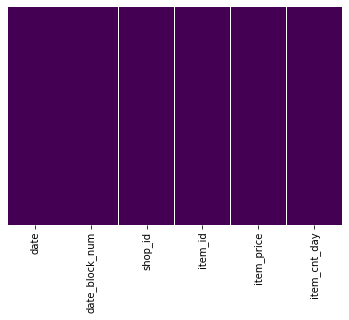

In [77]:
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

No missing values observed in data frame train

In [78]:
for column in df_train:
    unique_values = np.unique(df_train[column])
    print("The number of unique values in feature {} is: {}".format(column, len(unique_values)))

The number of unique values in feature date is: 1034
The number of unique values in feature date_block_num is: 34
The number of unique values in feature shop_id is: 60
The number of unique values in feature item_id is: 21807
The number of unique values in feature item_price is: 19993
The number of unique values in feature item_cnt_day is: 198


In [79]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


- We can observe that the variable target (item_cnt_day) has float values. We would expect to have only int values in this column since it reflects the number of items sold
-We also observe negative values in columns item_price and item_cnt_day. We could consider these entries as errors (to be erased) since the price of an item shouldnt be negative nor it is possible to sell negative values of an item (unless negative values means it was a return?). 
- We observe that the 75th quartile in item_cnt_day is 1.00, which means that 75% of the items sold each day was <= to 1, whereas the max value is 2169. We observe a similar behavior in item_price were 75% of the price is <= 999, but the max value is 307980. This indicate that we might have signifcant outliers.


In [80]:
# data frame: items
df_items.sample(5)

,item_name,item_id,item_category_id
12996,КРУТЫЕ ГОНКИ,12996,40
18444,СБ. Соль Наши музыкальные традиции 2,18444,55
18629,СЕМНАДЦАТЬ МГНОВЕНИЙ ВЕСНЫ (6 dvd) (Регион),18629,40
7410,V/A Om Music Diamonds 2CD (digipack),7410,55
5816,"Plants vs. Zombies Garden Warfare [Xbox 360, р...",5816,23


**Information about the features in file: items**

- **item_name:** name of item
-**item_id:** unique identifier of a product
-**item_category_id:** unique identifier of item category

In [81]:
df_items.shape

(22170, 3)

In [82]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [83]:
if df_items.isnull().sum().sum()==0:
    print('There are no missing values in this dataset')
else:
    print(df_items.isnull().sum()/len(df_items)*100)

There are no missing values in this dataset


In [84]:
# data frame: item categories
df_itemcat.sample(5)

,item_category_name,item_category_id
83,Элементы питания,83
58,Музыка - Винил,58
79,Служебные,79
63,Подарки - Мягкие игрушки,63
7,Аксессуары - XBOX ONE,7


**Information about the features in file: items category**

- **item_category_name:** name of item category
- **item_category_id:** unique identifier of item category

In [85]:
df_itemcat.shape

(84, 2)

In [86]:
df_itemcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [87]:
if df_itemcat.isnull().sum().sum()==0:
    print('There are no missing values in this dataset')
else:
    print(df_itemcat.isnull().sum()/len(df_itemcat)*100)

There are no missing values in this dataset


In [88]:
# data frame: shops
df_shops.sample(5)

,shop_name,shop_id
33,"Мытищи ТРК ""XL-3""",33
59,"Ярославль ТЦ ""Альтаир""",59
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",28
24,"Москва ТК ""Буденовский"" (пав.К7)",24
29,"Москва ТЦ ""Новый век"" (Новокосино)",29


**Information about the features in file: items category**

- **shop_name:** name of shop
- **shop_id:** unique identifier of a shop

In [89]:
df_shops.shape

(60, 2)

In [90]:
df_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [91]:
if df_shops.isnull().sum().sum()==0:
    print('There are no missing values in this dataset')
else:
    print(df_shops.isnull().sum()/len(df_shops)*100)

There are no missing values in this dataset


### **Exploratory Analysis - Dataset train** 

In [92]:
df_train['date']=df_train['date'].apply(lambda x:datetime.datetime.strptime(x,'%d.%m.%Y')) #changing date format to access day, month, year info
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [93]:
df_explore = df_train.copy()

As we mentioned before, we have some values that could be errased from the dataset:
- item_cnt_day<0
- item_price<0

In [94]:
df_explore.drop(df_explore.index[df_explore['item_cnt_day'] < 0], inplace=True)
df_explore.drop(df_explore.index[df_explore['item_price'] < 0], inplace=True)
df_explore.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.928492e+06,2.928492e+06,2.928492e+06,2.928492e+06,2.928492e+06
mean,1.456976e+01,3.300295e+01,1.020028e+04,8.894668e+02,1.248337e+00
std,9.422951e+00,1.622543e+01,6.324396e+03,1.727499e+03,2.619586e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [95]:
df_explore.shape

(2928492, 6)

In [96]:
target = 'item_cnt_day'
features = [col for col in df_explore.columns if col  not in [target]]
features

['date', 'date_block_num', 'shop_id', 'item_id', 'item_price']

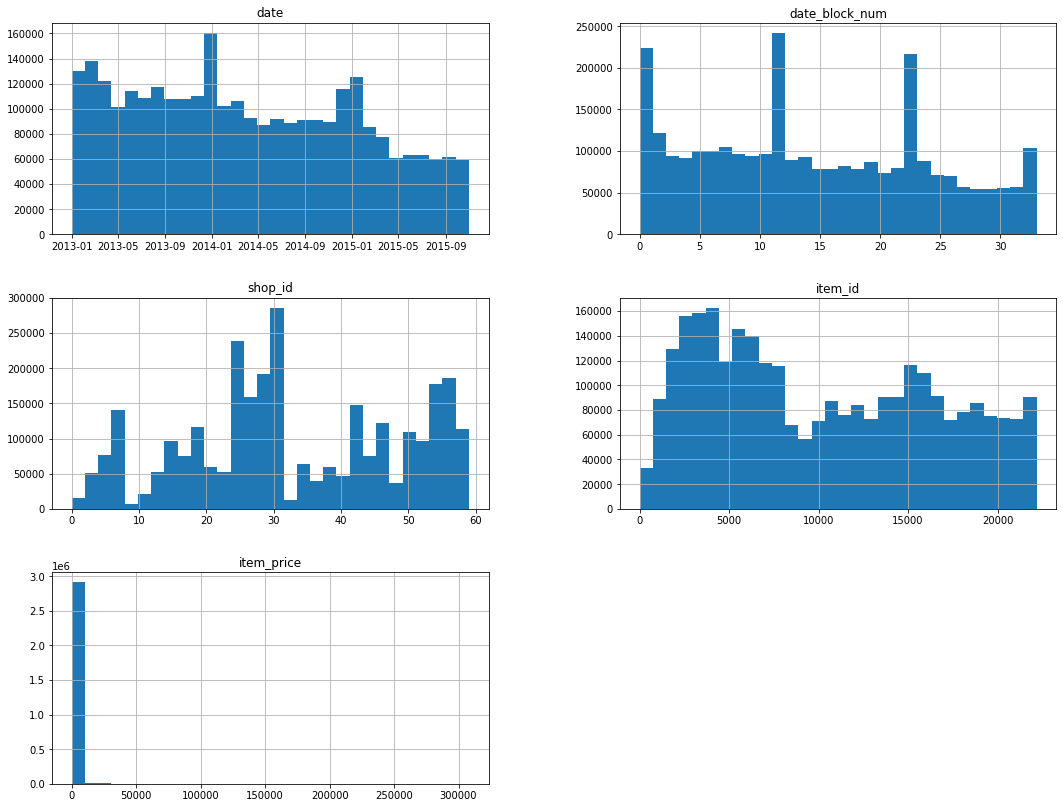

In [97]:
df_explore[features].hist(figsize=(18,14),bins=30)
plt.show()

- We can observe that the highest peak of sale usually happens around month 01.
- We have a clear skewed to the left distribuition in item_price with outliers

In [98]:
df_explore[df_explore['item_price']>50000]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,2013-09-17,8,12,11365,59200.0,1.0
1163158,2013-12-13,11,12,6066,307980.0,1.0
1488135,2014-03-20,14,25,13199,50999.0,1.0


In [99]:
df_items['item_name'][df_explore[df_explore['item_price']>50000]['item_id']]

11365                             Доставка (EMS)
6066                        Radmin 3  - 522 лиц.
13199    Коллекционные шахматы (Властелин Колец)
Name: item_name, dtype: object

- We can observe 3 items that are big outliers in item price that were sold only once each during the 3 years.  They might be items considered luxury or collectables. 

In [100]:
df_items_mostsold = df_explore.groupby('item_id')['item_cnt_day'].sum().to_frame().sort_values(['item_cnt_day'], ascending = False).head(5)
df_items_mostsold

,item_cnt_day
item_id,
20949,187660.0
2808,17255.0
3732,16676.0
17717,15830.0
5822,14522.0


In [101]:
df_explore['item_price'][df_items_mostsold.index]

item_id
20949     669.0
2808      399.0
3732      299.0
17717     349.0
5822     2199.0
Name: item_price, dtype: float64

In [102]:
print('The average price of items is', df_explore['item_price'].mean())

The average price of items is 889.466751271038


- The items that were sold the most during the 3 years have a price under the average, except for item 5822

In [103]:
df_items['item_name'][df_items_mostsold.index]

item_id
20949    Фирменный пакет майка 1С Интерес белый (34*42)...
2808                Diablo III [PC, Jewel, русская версия]
3732            Grand Theft Auto V [PS3, русские субтитры]
17717                 Прием денежных средств для 1С-Онлайн
5822     Playstation Store пополнение бумажника: Карта ...
Name: item_name, dtype: object

- At least three items that were sold the most during the 3 years are related to video games.

In [104]:
df_shop_mostsold = df_explore.groupby('shop_id')['item_cnt_day'].sum().to_frame().sort_values(['item_cnt_day'], ascending = False).head(5)
df_shop_mostsold

,item_cnt_day
shop_id,
31,311230.0
25,242237.0
54,186149.0
28,184777.0
42,145195.0


In [105]:
print('The shop that sold the most items was', '\n', df_shops['shop_name'][df_shop_mostsold.index].head(1))

The shop that sold the most items was 
 shop_id
31    Москва ТЦ "Семеновский"
Name: shop_name, dtype: object


### Clustering of items

In [106]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans

In [107]:
x = df_items.iloc[:,[1,2]].values
df_items.head()


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


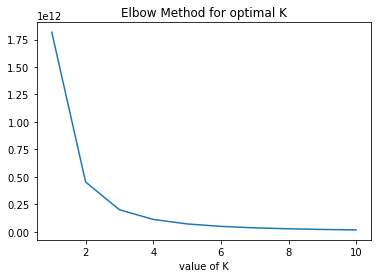

In [108]:
df_items['item_name']= LabelEncoder().fit_transform(df_items['item_name'])
X= df_items.iloc[:,[0,1]].values

w = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    w.append(kmeans.inertia_)
plt.plot(range(1, 11), w)
plt.title('Elbow Method for optimal K')
plt.xlabel('value of K')
plt.show()

From the Elbow method graph we can conclude that the optimal K for clustering is k=3

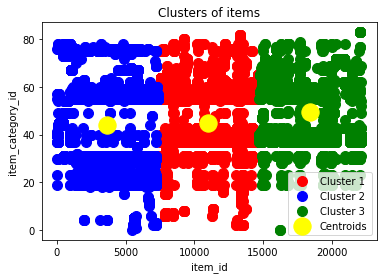

In [109]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(x)

plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of items')
plt.xlabel('item_id')
plt.ylabel('item_category_id')
plt.legend()
plt.show()

In [110]:
df_explore['month_year'] = df_explore['date'].apply(lambda x:x.strftime('%Y%m'))
df_explore.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year
0,2013-01-02,0,59,22154,999.00,1.0,201301
1,2013-01-03,0,25,2552,899.00,1.0,201301
3,2013-01-06,0,25,2554,1709.05,1.0,201301
4,2013-01-15,0,25,2555,1099.00,1.0,201301
5,2013-01-10,0,25,2564,349.00,1.0,201301


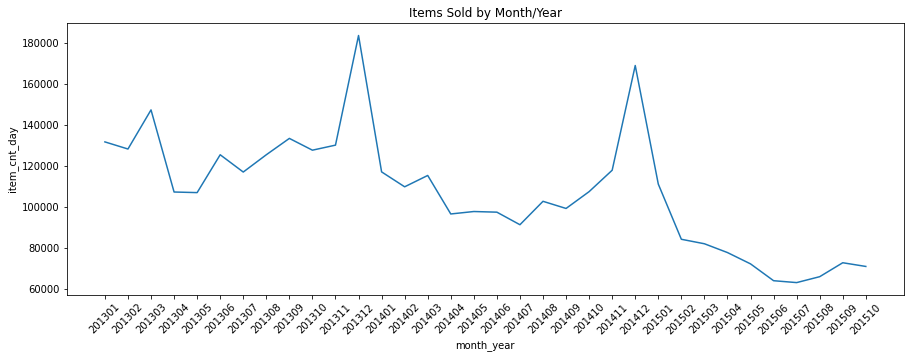

In [111]:
sales_per_month = df_explore.groupby('month_year')['item_cnt_day'].sum()

plt.figure(figsize=(15,5))
sns.lineplot(data=sales_per_month).set_title('Items Sold by Month/Year')
plt.xticks(rotation = 45)
plt.show()

In [112]:
df_explore['amount'] = df_explore['item_price'] * df_explore['item_cnt_day']
df_explore.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year,amount
0,2013-01-02,0,59,22154,999.00,1.0,201301,999.00
1,2013-01-03,0,25,2552,899.00,1.0,201301,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,201301,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,201301,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,201301,349.00


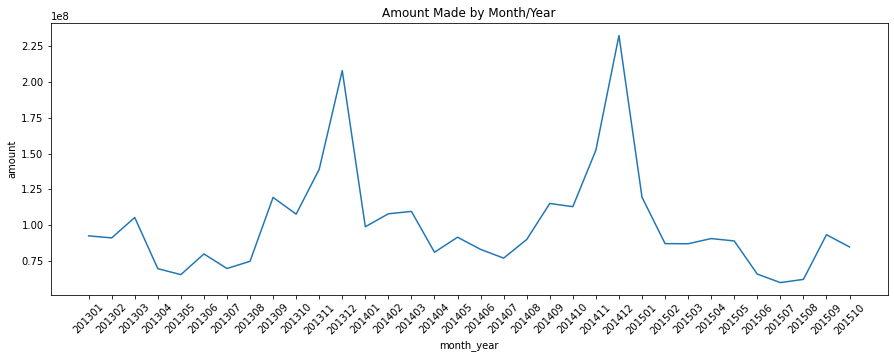

In [113]:
amount_per_month = df_explore.groupby('month_year')['amount'].sum()

plt.figure(figsize=(15,5))
sns.lineplot(data=amount_per_month).set_title('Amount Made by Month/Year')
plt.xticks(rotation = 45)
plt.show()

- We can observe that in all the 3 years the items sold start increasing significantly around november and dicrease in january. 
This could be due to events thanks giving, black friday and christmas when people tend to buy other things of what they usually buy like gifts and decorations.
-The amount of money made in each month for every year seems to be similar around the years with a significant increase trough the months of November and December.

When prediciting the sales for the end of the year 2015 we would expect also a similar behavior.

In [114]:
df_explore.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year,amount
0,2013-01-02,0,59,22154,999.00,1.0,201301,999.00
1,2013-01-03,0,25,2552,899.00,1.0,201301,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,201301,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,201301,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,201301,349.00


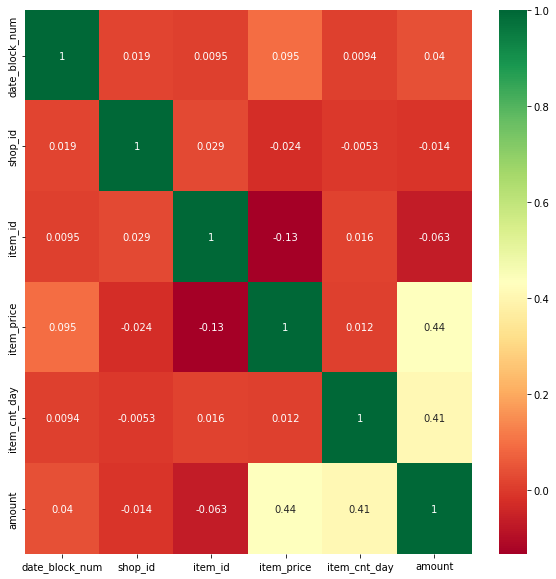

In [115]:
plt.figure(figsize=(10,10))
sns.heatmap(df_explore.corr(), annot=True, cmap="RdYlGn")

- We observe that there is not a significant correlation between the features. - The highest correlation is between amount and item_price, and amount and item_cnt_day which is expected.
- We might need to use other methode for feature engineering to choose the best feautres for our model, or use them all.

##**Model: SARIMA**

The SARIMA model is an extension of the widely used forecasting method ARIMA. The main difference with the SARIMA model is that it supports direct modeling of the seasonal component present in time series.  


There are two important aspects that need to be analized in order to be able to apply a SARIMA model:
- Trend: Pattern in the data that shows the movement of a series to relatively higher or lower values over a long period of time.

- Seasonality: Predictable pattern that recurs or repeats over regular intervals. Seasonality is often observed within a year or less.

From these two aspect there are 7 parameters that need to be calculated to use the SARIMA model:

- p and seasonal P: indicate number of autoregressive terms (lags of the stationarized series)
- d and seasonal D: indicate differencing that must be done to stationarize series
- q and seasonal Q: indicate number of moving average terms (lags of the forecast errors)
- s: indicates seasonal length in the data

#### Trend & Seasonality:


In [116]:
import statsmodels.api as sm

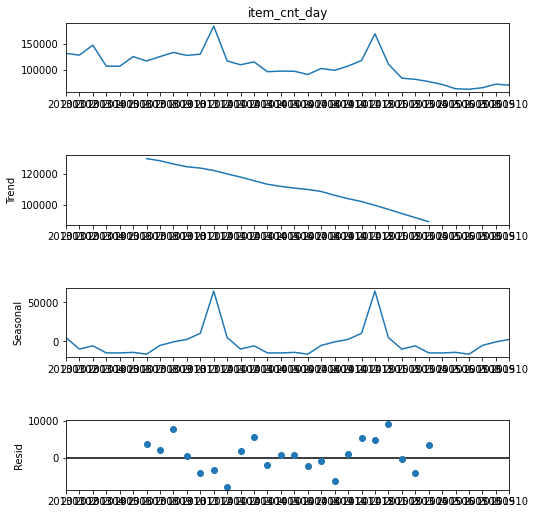

In [117]:
sm.tsa.seasonal_decompose(sales_per_month, period=12, model='additive').plot().set_size_inches(8,8) #if getting error change word 'freq' for 'period', or visceversa
#plt.xticks(rotation = 45)
plt.show()

- From the graph Trend above we can conclude that our dataset presents a **Downtrend**.

- From the graph Seasonal we can observe that we present two peaks. As we observed in the Exploratory Analysis of our dataset, we have a significant increase in the number of items sold and the amount of sales during winter (Nov to Dec) that was reapeated in years 2013 and 2014, and we can even see the beginning of the peak in novemeber 2015. Thus, we can conclude that our data has a **seasonal component**.

#### Stationarity:

Stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time.

We already confirmed that our dataset has a trend and a seasonal component, thus, is very likely that we are using a non-stationary dataset. Nevertheless, we will apply the Augmented Dickey–Fuller test to determine if our dataset is stationary or not. 

In [118]:
from statsmodels.tsa.stattools import adfuller

In [119]:
print('Results of Dickey-Fuller Test:')

dftest = adfuller(sales_per_month, autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])

print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic   -2.392387
p-value           0.143897
dtype: float64


The Dickey-Fuller test uses the following null and alternative hypotheses:
  - H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

- HA: The time series is stationary.

Since the p-value we obtain from this test is higher than 0.05, we can't reject the null hypothesis. 
We conclude then that our dataset is **non- stationary**

Since we concluded that our model is non-stationary, we will transform our data by using the Differencing Method. 

##### Differencing Method




The differencing method can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality. Differencing is performed by subtracting the previous observation from the current observation.

In [120]:
sales_per_month=sales_per_month-sales_per_month.shift(12)
sales_per_month=sales_per_month.dropna()

In [121]:
print('Results of Dickey-Fuller Test:')

dftest = adfuller(sales_per_month, autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])

print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic   -3.262794
p-value           0.016626
dtype: float64


After applying the Differencing Method we obtained a p-value lower than 0.05. We can confirm that our dataset is now **stationary** 

#### AUTO-CORRELATION and PARTIAL AUTOCORRELATION

Finally, we wil look at the auto-correlation of our dataset to determine the degree of similarity between the time series and the lag over successive time periods.

This two graphs will help us calculate parameters **(p,d,q)x(P,D,Q,s)** needed for the SARIMA model.

In [122]:
#!pip install pmdarima 
#Only run this cell once: to install library pmdarima

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ARIMA
from pmdarima.arima import auto_arima

In [124]:
#Transforming sales_per_month to have column 'date' as index and be able to calculate the time series lag
sales_per_month = df_explore.groupby(['month_year'])['date', 'item_cnt_day'].agg({'date':'min', 'item_cnt_day':'sum'})
sales_per_month.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)
sales_per_month.set_index(['date'], inplace=True)
sales_per_month.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,item_cnt_month
date,
2013-01-01,131850.0
2013-02-01,128382.0
2013-03-01,147438.0
2013-04-01,107439.0
2013-05-01,107147.0


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


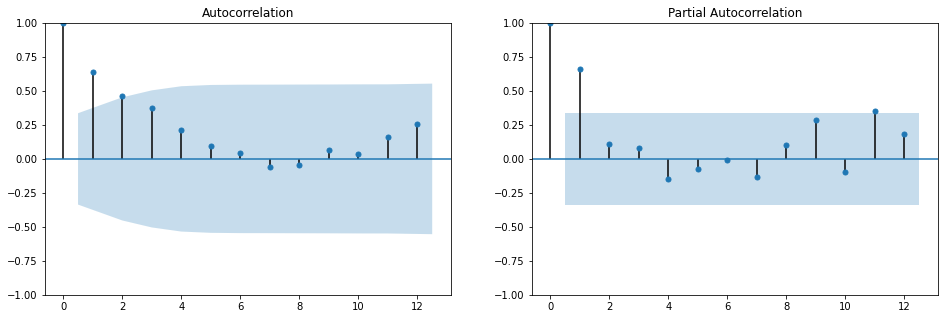

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(sales_per_month,lags=12, ax=axes[0])
plot_pacf(sales_per_month,lags=12, ax=axes[1])
plt.show()

In [126]:
model_sarima=auto_arima(sales_per_month, start_p = 0, start_q = 0,D=1, m = 12, seasonal = True, test = "adf",  trace = True, alpha = 0.05, information_criterion = 'aic', suppress_warnings = True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=448.712, Time=0.18 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=451.694, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=449.375, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=438.028, Time=0.16 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=439.322, Time=0.24 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=438.106, Time=0.13 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=440.633, Time=0.38 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=448.567, Time=0.05 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=451.371, Time=0.13 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=449.059, Time=0.18 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=inf, T

From the model we obtained that the best combination of parameters is:
**p = 0, d = 2, q = 1, P = 0, D = 1, and Q = 1**


In [127]:
print(model_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -216.014
Date:                            Mon, 15 Aug 2022   AIC                            438.028
Time:                                    22:20:22   BIC                            441.016
Sample:                                         0   HQIC                           438.611
                                             - 34                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9858      0.299     -3.301      0.001      -1.571      -0.401
ma.S.L12      -0.0853      0.167   

From the SARIMAX results we conclude:
- Ljung-Box > 0.05: Residuals are independent.
- Heteroskedasticity > 0.05: Fail to reject the null hypothesis of Homoscedasticity.
- Jarque Bera > 0.05: Sample data follows normal distribution

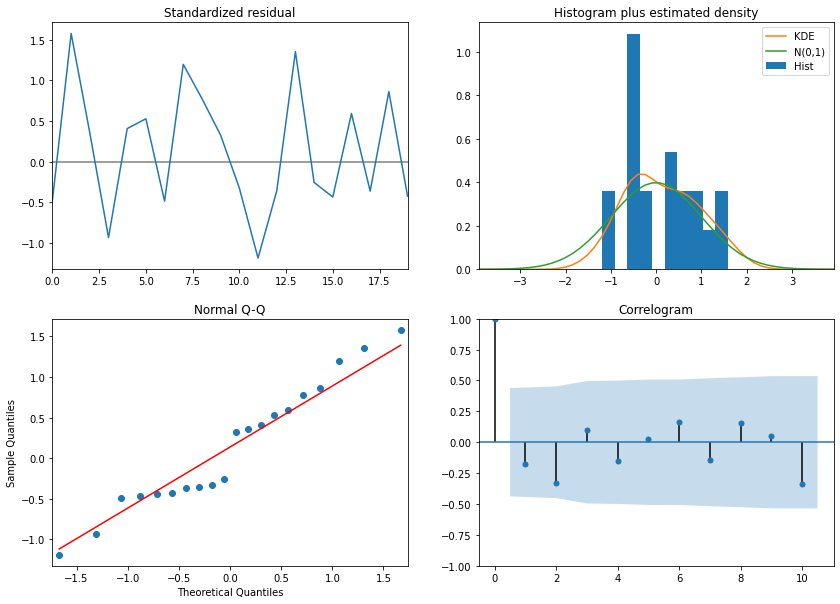

In [128]:
model_sarima.plot_diagnostics(figsize=(14,10))
plt.show()

From the plot diagnostics we can observe:
- The residuals errors seem to fluctuate around a mean of zero.
- The density plot suggest that the data follows a normal distribution sligthly skewed to the left.
- As we see from the Sample Quantities plot, not all the dots fall perfectly in the red line, nevertheless they are not far away from it either. We can imply the distribution is skewed as we saw in the histogram.
- The correlogram plot shows that the residual errors are not autocorrelated.

Overall, the model seems like a good fit, we can proceed to do a forecast

### Prediction - Future Sales by months

In [129]:
prediction, confint = model_sarima.predict(n_periods = 7, return_conf_int = True)
period_index = pd.period_range(start = sales_per_month.index[-1], periods = 7, freq='M')
sales_per_month_forecast = pd.DataFrame({'Predicted item_cnt_month': prediction.round(2)}, index = period_index)

sales_per_month_forecast['date'] = sales_per_month_forecast.index
sales_per_month_forecast['date'] = sales_per_month_forecast['date'].apply(lambda x: x.strftime('%Y-%m'))
sales_per_month_forecast.set_index('date', inplace=True)
sales_per_month_forecast.head(7)

,Predicted item_cnt_month
date,
2015-10,78010.30
2015-11,125925.95
2015-12,65870.27
2016-01,37780.98
2016-02,33427.73
2016-03,24867.50
2016-04,17003.73


In [130]:
sales_per_month= sales_per_month.reset_index()
sales_per_month['date'] = sales_per_month['date'].apply(lambda x: x.strftime('%Y-%m'))
sales_per_month.set_index('date', inplace=True)
sales_per_month.head()

,item_cnt_month
date,
2013-01,131850.0
2013-02,128382.0
2013-03,147438.0
2013-04,107439.0
2013-05,107147.0


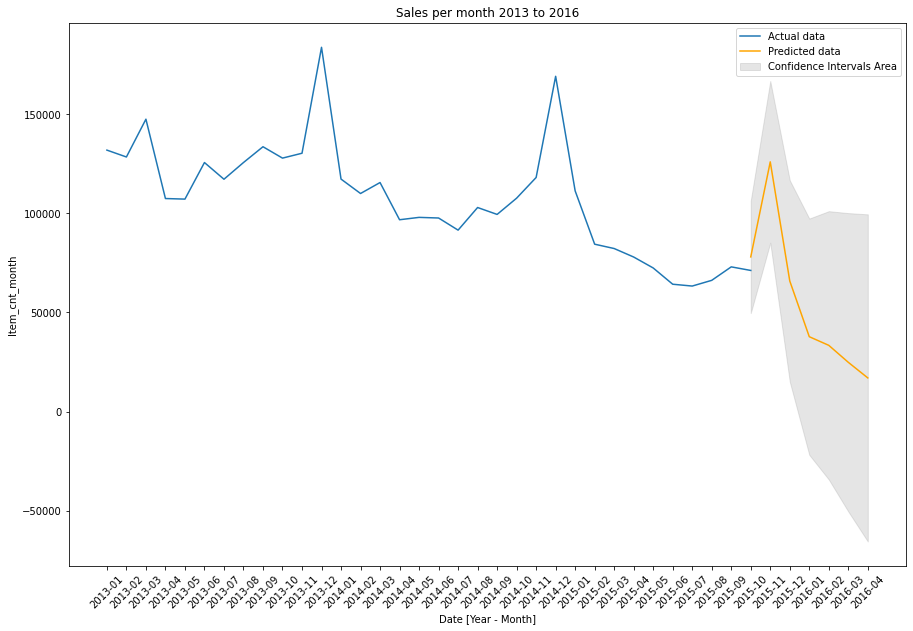

In [131]:
cf= pd.DataFrame(confint)

plt.figure(figsize=(15,10))
plt.plot(sales_per_month, label='Actual data')
plt.plot(sales_per_month_forecast, color='orange', label='Predicted data')
plt.fill_between(sales_per_month_forecast.index, cf[0],cf[1], color='grey', alpha=.2, label='Confidence Intervals Area')
plt.xticks(rotation = 45)
plt.title('Sales per month 2013 to 2016')
plt.xlabel('Date [Year - Month]')
plt.ylabel('Item_cnt_month')
plt.legend()
plt.show()

### Conclusion

This project showed that using a SARIMA model to predict the sales of the following six months for 1C
Company, can generate a reliable and accurate forecast. Even though the model struggled to fit the initial
value of the forecast (as observed in October 2015, see Figure 14), it quickly learnt and captured the
seasonality and trending behavior within the dataste to produce a more fitted prediction for the desired
months. These predictions can be incredibly useful for the 1C company as knowing the approximate
sales volume will give them key info on how much stock to order, how many staff do they need for each
month, project profits and other important aspects of the business.